In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('data/mnist_train.csv')
y = train.label.values
x = train.loc[:,train.columns != "label"].values/255


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [32]:
batch_size = 128
n_iters = 10001
epochs = int(n_iters / (len(x_train) / batch_size))
epochs

38

In [33]:
x_train_tensor = torch.from_numpy(x_train)
x_test_tensor = torch.from_numpy(x_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)


In [34]:
train=TensorDataset(x_train_tensor,y_train_tensor)
test=TensorDataset(x_test_tensor,y_test_tensor)

train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False)



In [8]:
class ann(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(ann,self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.elu = nn.ELU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self,input):
        x = self.fc1(input)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.elu(x)
        x = self.fc4(x)
        return x
    
input_dim = 28*28
hidden_dim = 150
output_dim = 10

model = ann(input_dim,hidden_dim,output_dim)   

error = nn.CrossEntropyLoss()

learning_rate=0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [9]:
counter = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(epochs + 1):
    for i, (images, labels) in enumerate(train_loader):
        train = images.view(-1, 28 * 28).type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
        optimizer.zero_grad()
        
        outputs = model(train)
        
        loss = error(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        counter += 1
        
        if counter % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = images.view(-1, 28*28).float()
                
                outputs = model(test)
                
                predicted = torch.max(outputs.data, 1)[1]
                
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(counter)
            accuracy_list.append(accuracy)
        if counter % 500 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(counter, loss.data, accuracy))

Iteration: 500  Loss: 0.8166375756263733  Accuracy: 78.70237731933594 %
Iteration: 1000  Loss: 0.45555341243743896  Accuracy: 87.67857360839844 %
Iteration: 1500  Loss: 0.23600313067436218  Accuracy: 89.52381134033203 %
Iteration: 2000  Loss: 0.3037587106227875  Accuracy: 90.63095092773438 %
Iteration: 2500  Loss: 0.2994420826435089  Accuracy: 91.76190185546875 %
Iteration: 3000  Loss: 0.12159520387649536  Accuracy: 92.54762268066406 %
Iteration: 3500  Loss: 0.2276410609483719  Accuracy: 93.27381134033203 %
Iteration: 4000  Loss: 0.07576058059930801  Accuracy: 93.88095092773438 %
Iteration: 4500  Loss: 0.2979617416858673  Accuracy: 94.36904907226562 %
Iteration: 5000  Loss: 0.10529286414384842  Accuracy: 94.83333587646484 %
Iteration: 5500  Loss: 0.19573397934436798  Accuracy: 94.89286041259766 %
Iteration: 6000  Loss: 0.16923613846302032  Accuracy: 95.27381134033203 %
Iteration: 6500  Loss: 0.08686263114213943  Accuracy: 95.52381134033203 %
Iteration: 7000  Loss: 0.11785008758306503  

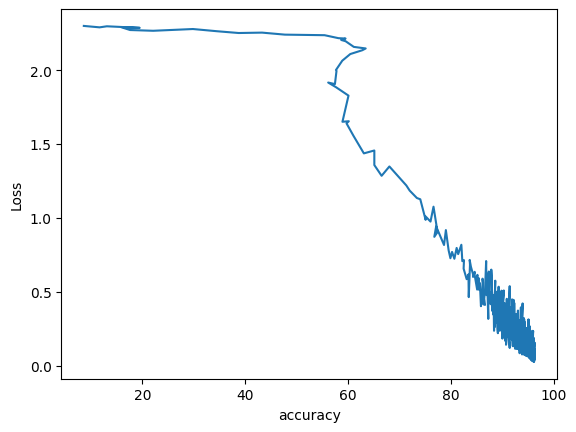

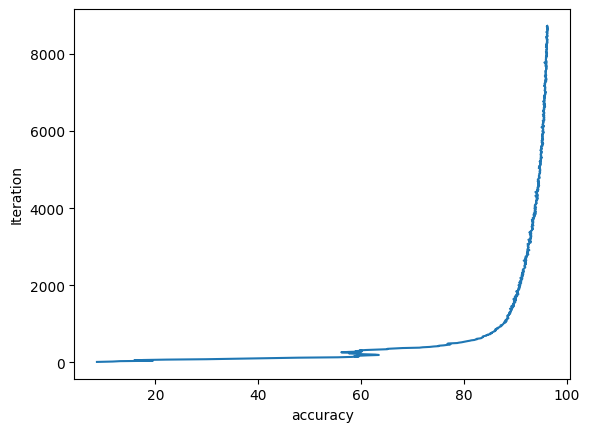

In [10]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list,loss_list)
plt.xlabel("accuracy")
plt.ylabel("Loss")
plt.show()

plt.plot(accuracy_list,iteration_list)
plt.xlabel("accuracy")
plt.ylabel("Iteration")
plt.show()

In [35]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.15)
        self.fc1 = None
        self.fc2 = None
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        if self.fc1 is None:
            self.fc1 = nn.Linear(out.view(out.size(0), -1).size(1),128)
            self.fc2 = nn.Linear(128,10)
        out = out.view(out.size(0),-1) #flatten
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


cnn_model = cnn()

cnn_error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(cnn_model.parameters(),lr=learning_rate)


In [38]:
counter = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs + 1):
    for i, (images, labels) in enumerate(train_loader):

        train = images.view(-1,1,28,28).type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)

        optimizer.zero_grad()
        outputs = cnn_model(train)
        loss = cnn_error(outputs, labels)
        loss.backward()
        optimizer.step()
        
        counter += 1
        if counter % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = images.view(-1,1,28,28).float()
                outputs = cnn_model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            iteration_list.append(counter)
            accuracy_list.append(accuracy)

            if counter % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(counter, loss.data, accuracy))

Iteration: 500  Loss: 0.7032926082611084  Accuracy: 77.5952377319336 %
Iteration: 1000  Loss: 0.6554661989212036  Accuracy: 82.94047546386719 %
Iteration: 1500  Loss: 0.3448687493801117  Accuracy: 85.41666412353516 %
Iteration: 2000  Loss: 0.44031310081481934  Accuracy: 86.69047546386719 %
Iteration: 2500  Loss: 0.35040968656539917  Accuracy: 88.78571319580078 %
Iteration: 3000  Loss: 0.2643626630306244  Accuracy: 89.0 %
Iteration: 3500  Loss: 0.29896941781044006  Accuracy: 89.33333587646484 %
Iteration: 4000  Loss: 0.3412095606327057  Accuracy: 90.21428680419922 %
Iteration: 4500  Loss: 0.32354241609573364  Accuracy: 90.23809814453125 %
Iteration: 5000  Loss: 0.27624309062957764  Accuracy: 91.10713958740234 %
Iteration: 5500  Loss: 0.25118470191955566  Accuracy: 91.47618865966797 %
Iteration: 6000  Loss: 0.21837006509304047  Accuracy: 91.60713958740234 %
Iteration: 6500  Loss: 0.25474420189857483  Accuracy: 92.0 %
Iteration: 7000  Loss: 0.17063815891742706  Accuracy: 92.67857360839844

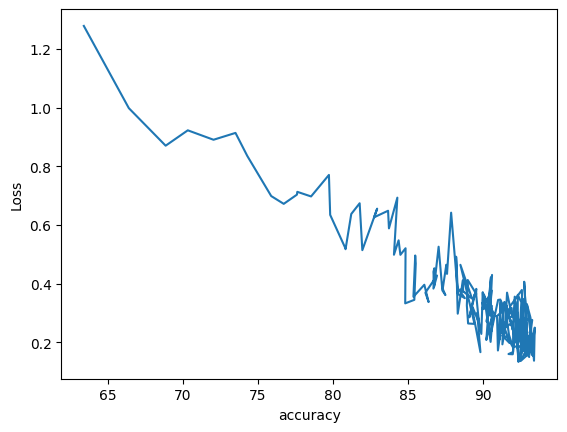

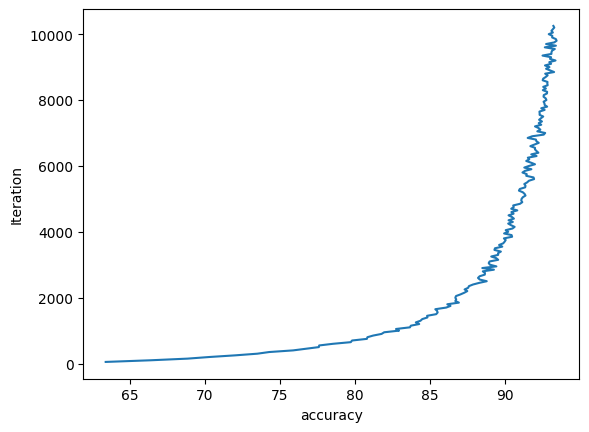

In [39]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list,loss_list)
plt.xlabel("accuracy")
plt.ylabel("Loss")
plt.show()

plt.plot(accuracy_list,iteration_list)
plt.xlabel("accuracy")
plt.ylabel("Iteration")
plt.show()